In [311]:
import string
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from collections import Counter
from nltk.tokenize import TweetTokenizer
from textblob import TextBlob

In [312]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/coich/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/coich/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [313]:
df = pd.read_csv('food.tsv', sep = '\t', encoding='latin-1')
df.head(1)

,productid,userid,score,text
0,B001E4KFG0,A3SGXH7AUHU8GW,5.0,I have bought several of the Vitality canned d...


In [314]:
df['text'] = df['text'].str.lower()
# df['text'] = df['text'].str.replace('.', ' . ')
df['text'] = [BeautifulSoup(review, 'html.parser').get_text() for review in df['text']]

reviews = df['text']

In [315]:
import re

def counting(reviews):
    tags = []

    for review in reviews:
        tag = re.findall('<[^<>]*>', review)
        if tag:
            tags.append(tag)

    tags = [item for tag in tags for item in tag]
    counter_tags = Counter(tags)
    print(counter_tags.most_common(10))

counting(reviews)

[('<>', 4), ('<g>', 2), ('<just pour the powder to 32oz water bottle and shake well - directions on the box say to use 500ml(16.9oz) but the tea is really strong so we use 1l bottle)>', 1), ('<grin>', 1), ('<sigh>', 1), ('<smile>', 1), ('<vbg>', 1)]


### Preprocessing sentences

In [316]:
tokenizer = TweetTokenizer(reduce_len=True, strip_handles=True)
reviews_tokenized = reviews.apply(tokenizer.tokenize)
reviews_tokenized.head(1)

0    [i, have, bought, several, of, the, vitality, ...
Name: text, dtype: object

In [317]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
#stop.add('fdsg')

reviews_tokenized = reviews_tokenized.apply(lambda review: [item for item in review if item not in stop])
reviews_tokenized.head(1)

0    [bought, several, vitality, canned, dog, food,...
Name: text, dtype: object

In [318]:
from nltk import wordpunct_tokenize
punctuation = string.punctuation

reviews_tokenized = reviews_tokenized.apply(lambda review: [item for item in review if item not in punctuation])
reviews_tokenized.head(1)

0    [bought, several, vitality, canned, dog, food,...
Name: text, dtype: object

In [234]:
from nltk.stem.lancaster import LancasterStemmer
lancaster_stemmer = LancasterStemmer()

reviews_tokenized = reviews_tokenized.apply(lambda review: [lancaster_stemmer.stem(item) for item in review])
reviews_tokenized.head(1)

0    [i, bought, sev, vit, can, dog, food, produc, ...
Name: text, dtype: object

In [319]:
words_list = [item for review in reviews_tokenized for item in review]
counter_words = Counter(words_list)
counter_words.most_common(10)

[('like', 14246),
 ('good', 11297),
 ('coffee', 9776),
 ('great', 9733),
 ('taste', 9488),
 ('one', 9445),
 ('product', 8239),
 ('flavor', 8128),
 ('love', 7332),
 ('would', 7129)]

In [320]:
reviews_clean = [' '.join(review).lower() for review in reviews_tokenized]

df['clean_text'] = reviews_clean

In [321]:
def stars_to_sentiment(score):
    if score in [1, 2] :
        return 'negative'
    elif score in [4, 5] :
        return 'positive'
    else:
        return 'neutral'

In [322]:
df['score'] = pd.to_numeric(df['score'], downcast = 'integer')

df['sentiment'] = df['score'].apply(stars_to_sentiment)
df.head(1)

,productid,userid,score,text,clean_text,sentiment
0,B001E4KFG0,A3SGXH7AUHU8GW,5,i have bought several of the vitality canned d...,bought several vitality canned dog food produc...,positive


In [323]:
df.to_csv('clean_dataset.csv', sep = ';', index=False)

In [338]:
df = pd.read_csv('clean_dataset.csv', sep = ';', encoding='latin-1')
df.head()

,productid,userid,score,text,clean_text,sentiment
0,B001E4KFG0,A3SGXH7AUHU8GW,5,i have bought several of the vitality canned d...,bought several vitality canned dog food produc...,positive
1,B00813GRG4,A1D87F6ZCVE5NK,1,product arrived labeled as jumbo salted peanut...,product arrived labeled jumbo salted peanuts ....,negative
2,B000LQOCH0,ABXLMWJIXXAIN,4,this is a confection that has been around a fe...,confection around centuries light pillowy citr...,positive
3,B000UA0QIQ,A395BORC6FGVXV,2,if you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...,negative
4,B006K2ZZ7K,A1UQRSCLF8GW1T,5,great taffy at a great price. there was a wid...,great taffy great price wide assortment yummy ...,positive


### Some classification

In [286]:
def polarity(text_clean):
    line = TextBlob(text_clean)
    return line.sentiment.polarity

def subjectivity(text_clean):
    line = TextBlob(text_clean)
    return line.sentiment.subjectivity

In [287]:
df['polarity'] = df['clean_text'].apply(polarity)
df['subjectivity'] = df['clean_text'].apply(subjectivity)
df.head(1)

,productid,userid,score,text,clean_text,sentiment,polarity,subjectivity
0,B001E4KFG0,A3SGXH7AUHU8GW,5,i have bought several of the vitality canned d...,bought several vitality canned dog food produc...,positive,0.425,0.4


In [288]:
def sentiment_number(sentiment):
    if sentiment == 'negative':
        return -1
    elif sentiment == 'positive':
        return 1
    else:
        return 0

In [289]:
df['sentiment'] = df['sentiment'].apply(sentiment_number)
df.head(1)

,productid,userid,score,text,clean_text,sentiment,polarity,subjectivity
0,B001E4KFG0,A3SGXH7AUHU8GW,5,i have bought several of the vitality canned d...,bought several vitality canned dog food produc...,1,0.425,0.4


In [290]:
score_counter = Counter((df['score']-3)/2)
sentiment_counter = Counter(df['sentiment'])
polarity_counter = Counter(df['polarity'].round(1))

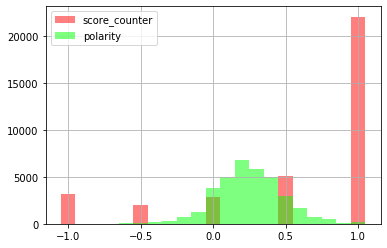

In [291]:
import matplotlib.pyplot as plt

legend = []
labels = []
colors = ['#ff0000', '#00ff00', '#0000ff']

legend.append(plt.bar(list(score_counter.keys()), list(score_counter.values()), \
                      width = 0.1, color = colors[0], alpha = 0.5)[0])
labels.append('score_counter')

#legend.append(plt.bar(list(sentiment_counter.keys()), list(sentiment_counter.values()), width = 0.1, color = colors[0])[0])
#labels.append('sentiment')

legend.append(plt.bar(list(polarity_counter.keys()), list(polarity_counter.values()), \
                      width = 0.1, color = colors[1], alpha = 0.5)[0])
labels.append('polarity')

plt.grid(True)
plt.legend(legend, labels)
plt.show()

### Based-Aspect Sentiment Analysis

In [339]:
df = pd.read_csv('clean_dataset.csv', sep = ';', encoding='latin-1')
df.head(1)

,productid,userid,score,text,clean_text,sentiment
0,B001E4KFG0,A3SGXH7AUHU8GW,5,i have bought several of the vitality canned d...,bought several vitality canned dog food produc...,positive


In [340]:
product_df = df[['productid']]
most_reviwed_products = product_df['productid'].value_counts()[:50]
most_reviwed_products = list(most_reviwed_products.index)

basa_df = pd.DataFrame()
basa_df = basa_df.append(df[df['productid'].isin(most_reviwed_products)])

basa_df.head()

,productid,userid,score,text,clean_text,sentiment
422,B000G6RYNE,A2NO1TXXS9T0EE,4,"great if you are cutting back on fat, they do ...",great cutting back fat resemble regular chips ...,positive
423,B000G6RYNE,A1IRN1M05TPOVT,5,i have never met a kettle brand chip i did not...,never met kettle brand chip like chips great l...,positive
424,B000G6RYNE,ARONI7W0W677H,5,after buying bags one at a time (at a hefty ma...,buying bags one time hefty markup nearby store...,positive
425,B000G6RYNE,A1Y3XPZK9ZADFW,4,"i buy mostly for vending, so the size of the b...",buy mostly vending size bag important kettle's...,positive
426,B000G6RYNE,A1Y3XPZK9ZADFW,4,glad to find these in a one ounce size but the...,glad find one ounce size bag seems bit less fu...,positive


In [341]:
lenghts = []
for index, row in basa_df.iterrows():
    text_splitted = row['text'].split('.')
    text_splitted = [phrase for phrase in text_splitted if phrase]
    lenghts.append(len(text_splitted))
basa_df['n_sentences'] = lenghts

basa_df.head()

,productid,userid,score,text,clean_text,sentiment,n_sentences
422,B000G6RYNE,A2NO1TXXS9T0EE,4,"great if you are cutting back on fat, they do ...",great cutting back fat resemble regular chips ...,positive,2
423,B000G6RYNE,A1IRN1M05TPOVT,5,i have never met a kettle brand chip i did not...,never met kettle brand chip like chips great l...,positive,4
424,B000G6RYNE,ARONI7W0W677H,5,after buying bags one at a time (at a hefty ma...,buying bags one time hefty markup nearby store...,positive,7
425,B000G6RYNE,A1Y3XPZK9ZADFW,4,"i buy mostly for vending, so the size of the b...",buy mostly vending size bag important kettle's...,positive,3
426,B000G6RYNE,A1Y3XPZK9ZADFW,4,glad to find these in a one ounce size but the...,glad find one ounce size bag seems bit less fu...,positive,6


### Input for ASUM

In [457]:
df = pd.read_csv('clean_dataset.csv', sep = ';', encoding='latin-1')
df.head(1)

,productid,userid,score,text,clean_text,sentiment
0,B001E4KFG0,A3SGXH7AUHU8GW,5,i have bought several of the vitality canned d...,bought several vitality canned dog food produc...,positive


In [458]:
product_df = df[['productid']]
most_reviwed_products = product_df['productid'].value_counts()[:50]
most_reviwed_products = list(most_reviwed_products.index)

basa_df = pd.DataFrame()
basa_df = basa_df.append(df[df['productid'].isin(most_reviwed_products)])

basa_df.head()

,productid,userid,score,text,clean_text,sentiment
422,B000G6RYNE,A2NO1TXXS9T0EE,4,"great if you are cutting back on fat, they do ...",great cutting back fat resemble regular chips ...,positive
423,B000G6RYNE,A1IRN1M05TPOVT,5,i have never met a kettle brand chip i did not...,never met kettle brand chip like chips great l...,positive
424,B000G6RYNE,ARONI7W0W677H,5,after buying bags one at a time (at a hefty ma...,buying bags one time hefty markup nearby store...,positive
425,B000G6RYNE,A1Y3XPZK9ZADFW,4,"i buy mostly for vending, so the size of the b...",buy mostly vending size bag important kettle's...,positive
426,B000G6RYNE,A1Y3XPZK9ZADFW,4,glad to find these in a one ounce size but the...,glad find one ounce size bag seems bit less fu...,positive


In [459]:
reviews = list(basa_df['text'])
len(reviews)

12112

In [460]:
reviews_phrases = [review.split('.') for review in reviews]

clean_reviews_phrases = []
for review in reviews_phrases:
    clean_reviews_phrases.append([phrase for phrase in review if phrase and not phrase == ' '])

In [461]:
asum_words = [phrase.split() for review in clean_reviews_phrases for phrase in review]
asum_words = [item for phrase in asum_words for item in phrase]
asum_words = sorted(set(asum_words))

with open('WordList.txt', 'w') as words_output:  
    words_output.writelines(f'{word}\n' for word in asum_words)
words_output.close()

len(asum_words)

30990

In [462]:
asum_words_dict = {}
for key, value in enumerate(asum_words):
    asum_words_dict[value] = key

In [464]:
with open('Phrase.txt', 'w') as phrase_output:  
    for review in clean_reviews_phrases:
        phrase_output.writelines(f'{len(review)}\n')
        for phrase in review:
            phrase_output.writelines(f'{asum_words_dict[item]} ' for item in phrase.split())
            phrase_output.writelines('\n')

phrase_output.close()